In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import visdom

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO
from pyro.optim import Adam

In [3]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [4]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [5]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [8]:
# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = torch.sigmoid(self.fc21(hidden))
        return loc_img

In [9]:
#define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            # return the loc so we can visualize it later
            return loc_img, z_loc, z_scale

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img, z_loc, z_scale

In [19]:
# parse command line arguments
parser = argparse.ArgumentParser(description="parse args")
parser.add_argument('-n', '--num-epochs', default=101, type=int, help='number of training epochs')
parser.add_argument('-tf', '--test-frequency', default=5, type=int, help='how often we evaluate the test set')
parser.add_argument('-lr', '--learning-rate', default=1.0e-3, type=float, help='learning rate')
parser.add_argument('--cuda', action='store_true', default=False, help='whether to use cuda')
parser.add_argument('--jit', action='store_true', default=False, help='whether to use PyTorch jit')
parser.add_argument('-visdom', '--visdom_flag', action="store_true", help='Whether plotting in visdom is desired')
parser.add_argument('-i-tsne', '--tsne_iter', default=100, type=int, help='epoch when tsne visualization runs')    
#args = parser.parse_args()

_StoreAction(option_strings=['-i-tsne', '--tsne_iter'], dest='tsne_iter', nargs=None, const=None, default=100, type=<class 'int'>, choices=None, help='epoch when tsne visualization runs', metavar=None)

In [10]:
class Args:
    num_epoch = 101
    learning_rate = 1.0e-3
    cuda = False
    jit = False
    visdom_flag = "store_true"
    tsne_iter = 100
args=Args()

====> Epoch: 1 Average loss: 191.5921
====> Test set loss: 157.4610
====> Epoch: 2 Average loss: 147.3554
====> Test set loss: 138.4870
====> Epoch: 3 Average loss: 133.3671
====> Test set loss: 127.7782
====> Epoch: 4 Average loss: 124.9278
====> Test set loss: 120.6138
====> Epoch: 5 Average loss: 119.5114
====> Test set loss: 116.6230
====> Epoch: 6 Average loss: 115.9506
====> Test set loss: 113.7548
====> Epoch: 7 Average loss: 113.6628
====> Test set loss: 111.7897
====> Epoch: 8 Average loss: 112.0815
====> Test set loss: 110.5479
====> Epoch: 9 Average loss: 110.8099
====> Test set loss: 109.6382
====> Epoch: 10 Average loss: 109.8761
====> Test set loss: 108.7651


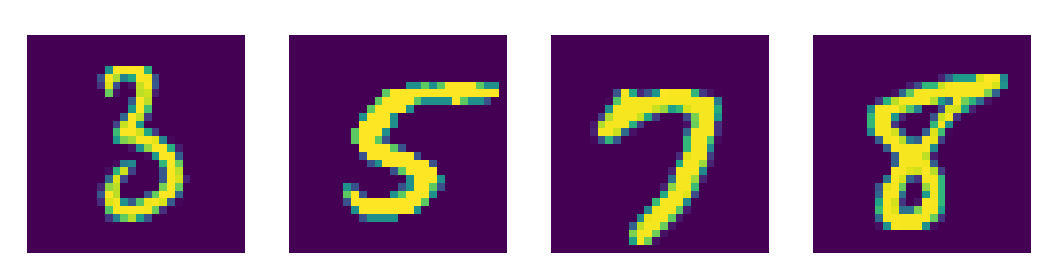

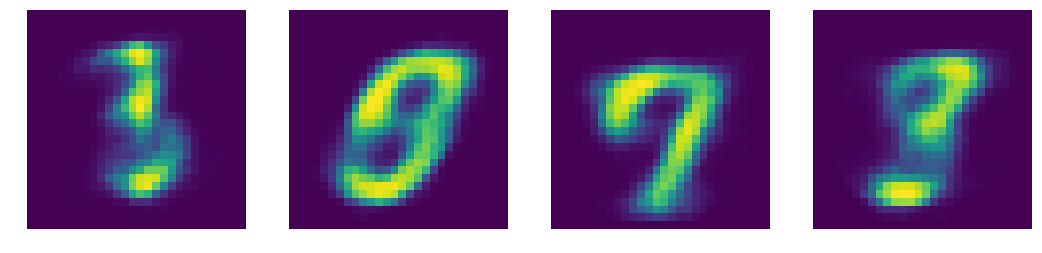

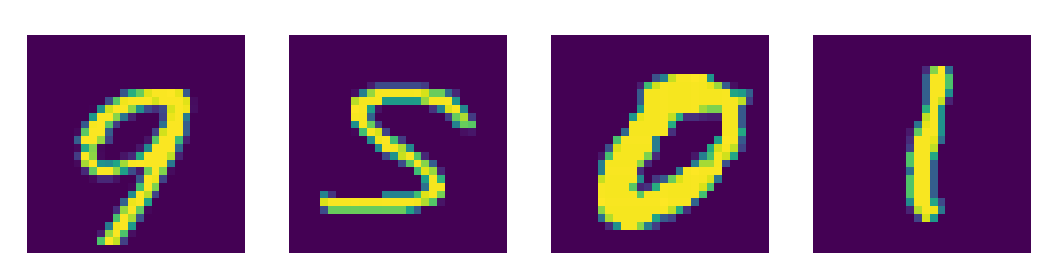

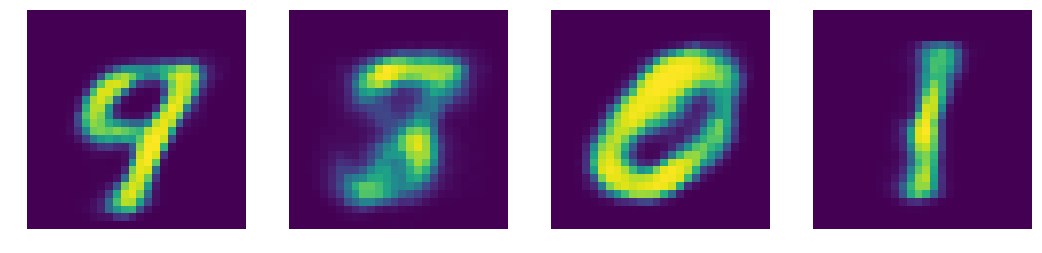

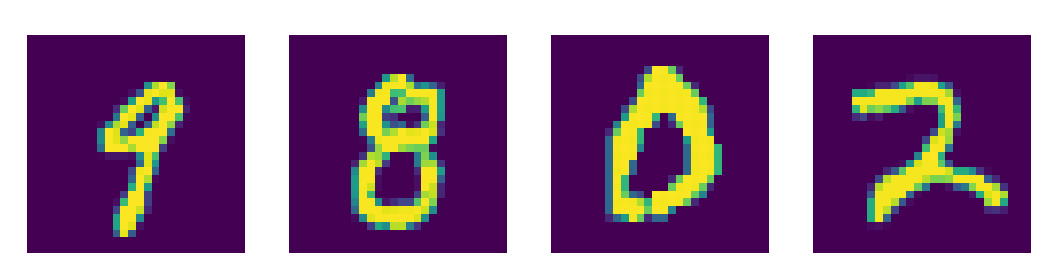

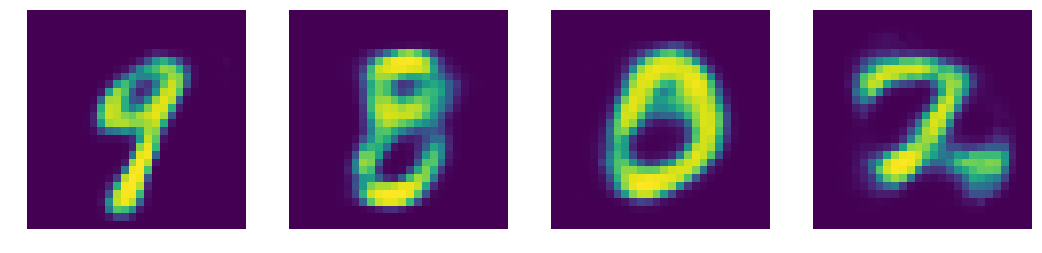

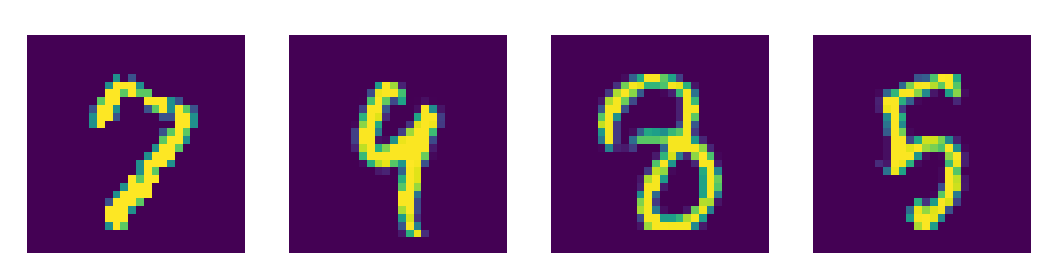

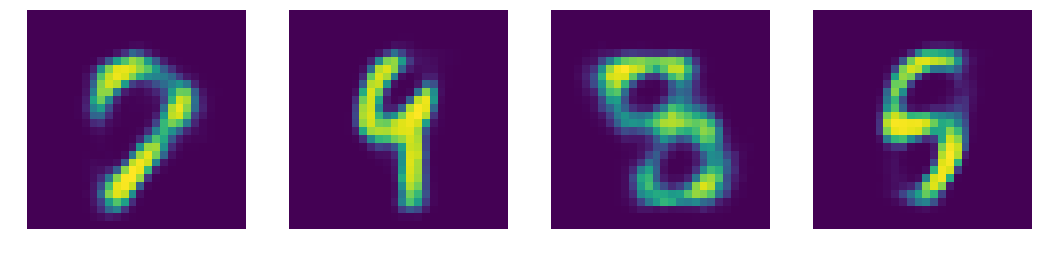

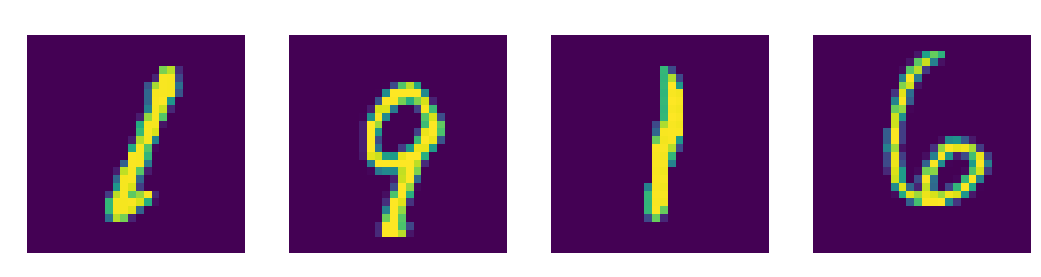

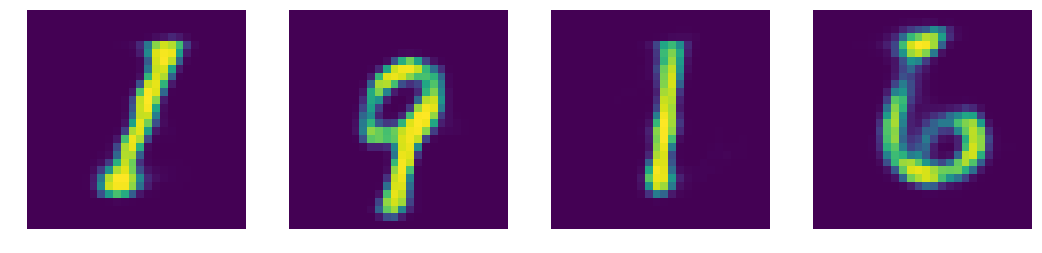

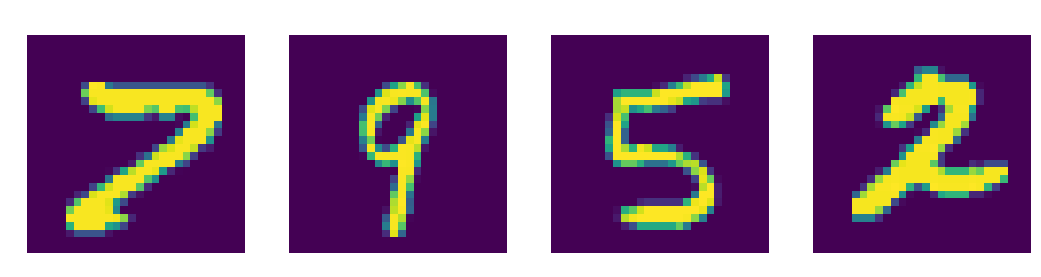

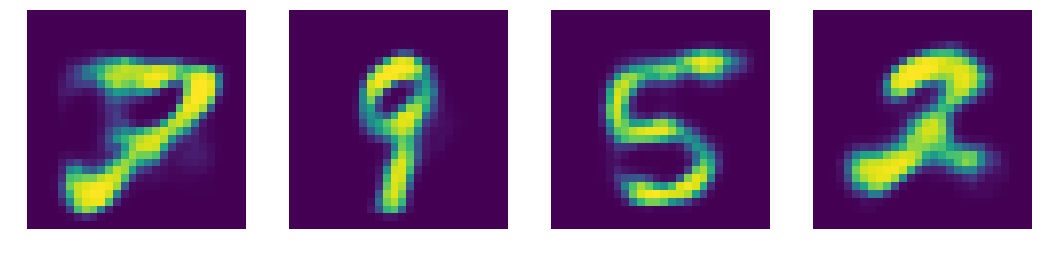

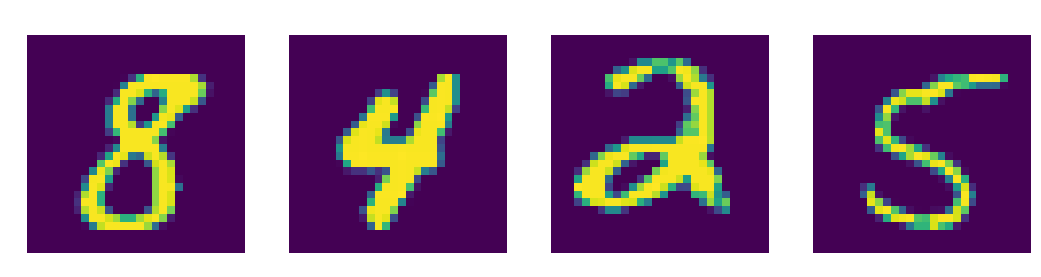

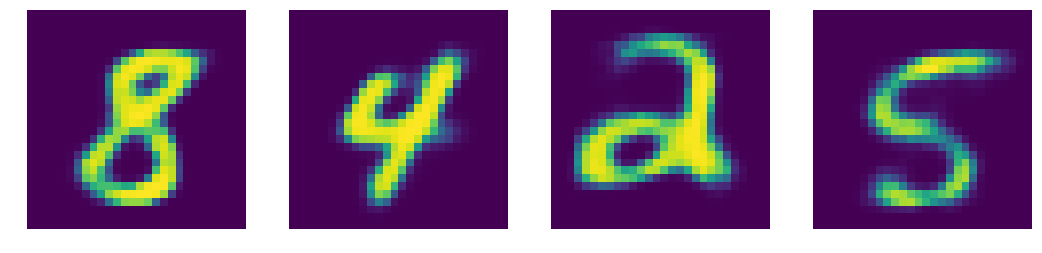

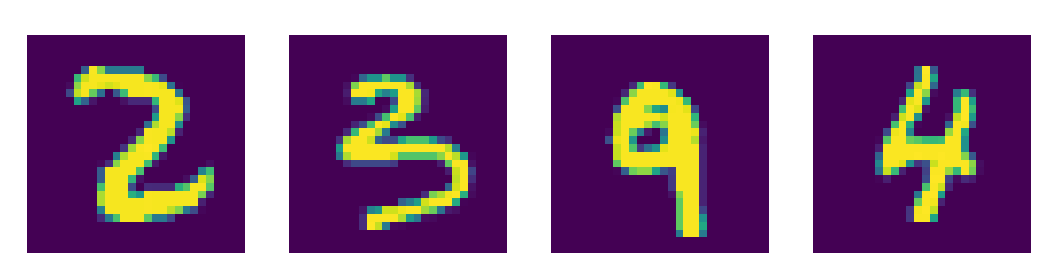

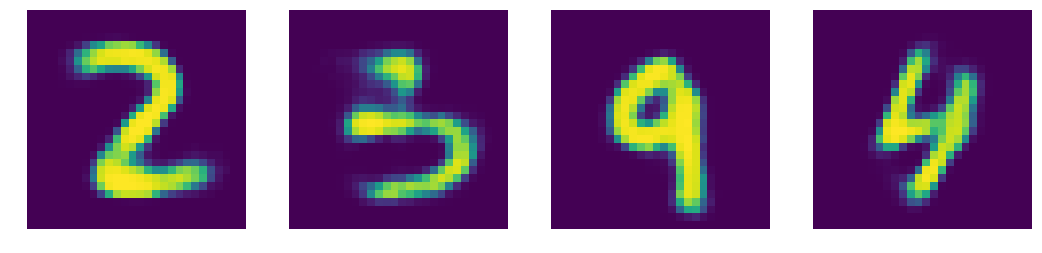

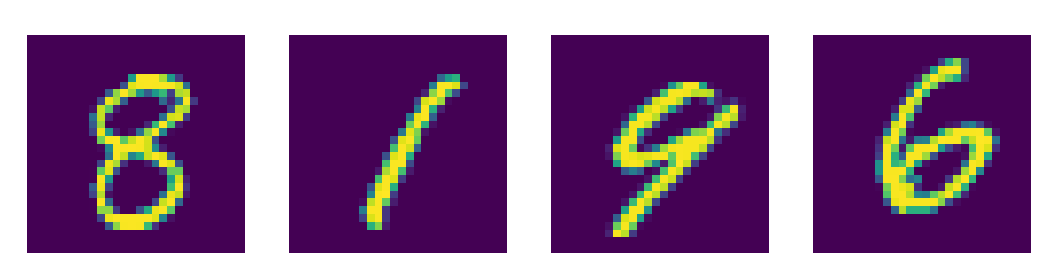

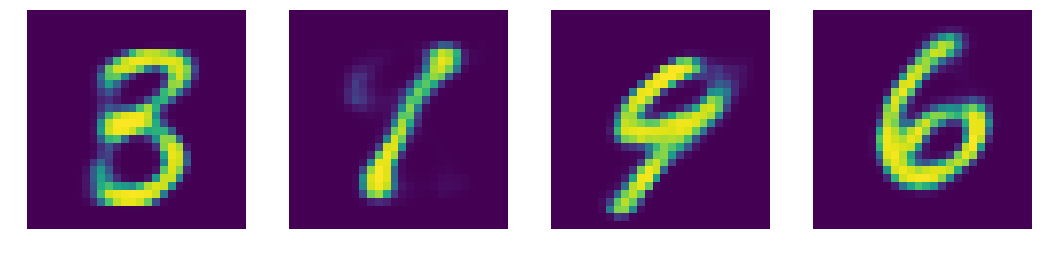

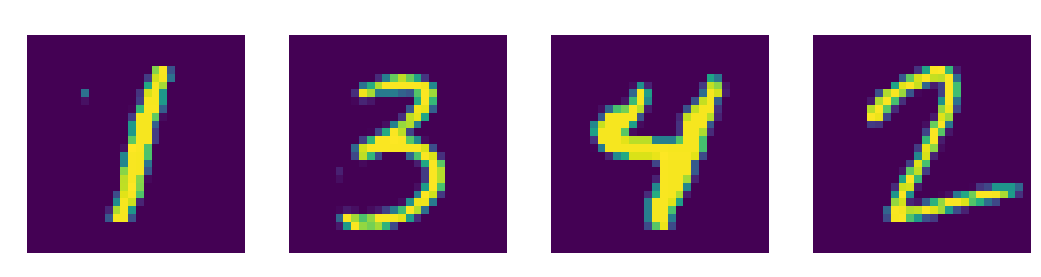

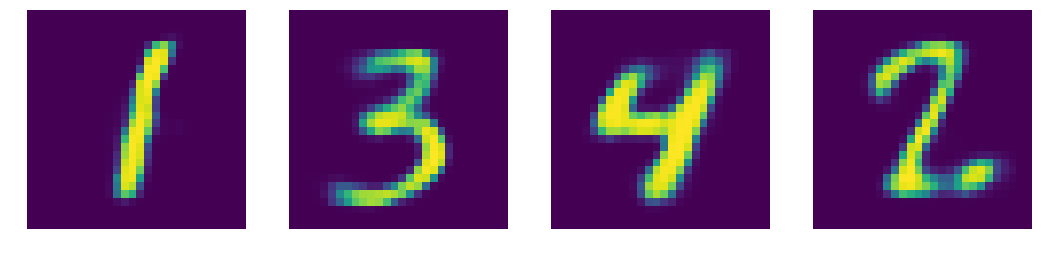

In [11]:
# clear param store
pyro.clear_param_store()
# Training and testing the VAE

# setup the VAE
vae = VAE(use_cuda=args.cuda)

# setup the optimizer
adam_args = {"lr": args.learning_rate}
optimizer = Adam(adam_args)

# setup the inference algorithm
elbo = JitTrace_ELBO() if args.jit else Trace_ELBO()
svi = SVI(vae.model, vae.guide, optimizer, loss=elbo)

# setup visdom for visualization
# if args.visdom_flag:
# vis = visdom.Visdom()

train_elbo = []
test_elbo = []
    
epochs = 10
for epoch in range(1, epochs + 1):
    # Training
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        train_loss += svi.step(x)
        with torch.no_grad():
            loc_img, z_loc, z_scale = vae.model(x)
    # ===================log========================
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    with torch.no_grad():
        test_loss = 0
        for x, _ in test_loader:
            x = x.to(device)
            test_loss += svi.evaluate_loss(x)
            x_hat, z_loc, z_scale = vae.reconstruct_img(x)
    # ===================log========================
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')  

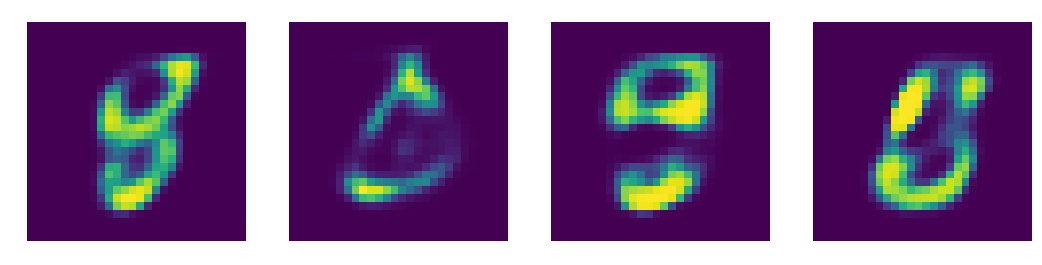

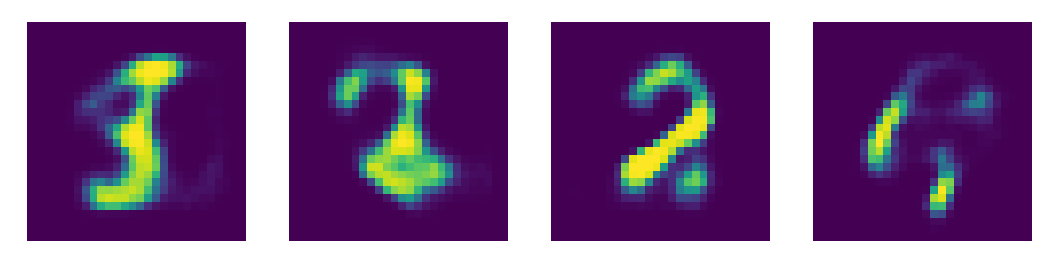

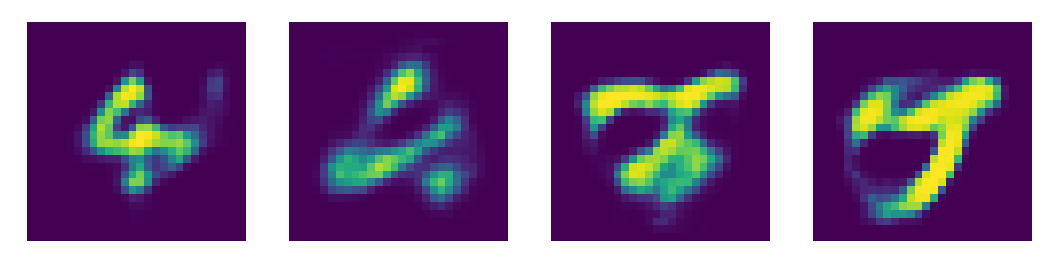

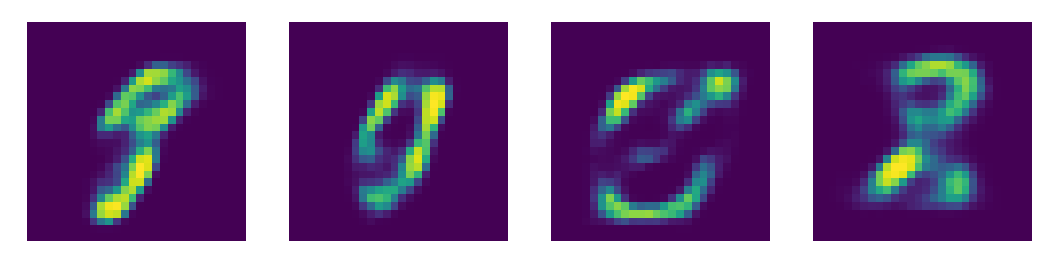

In [12]:
# Generating a few samples
d = 16
N = 50
z = torch.randn((d, N)).to(device)
sample = vae.decoder(z)
display_images(None, sample, d // 4, count=True)

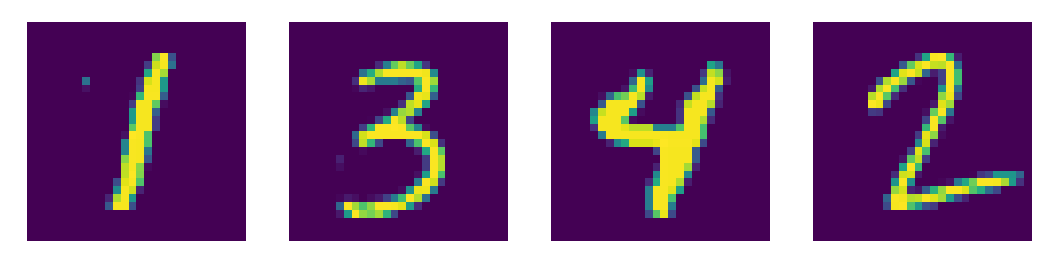

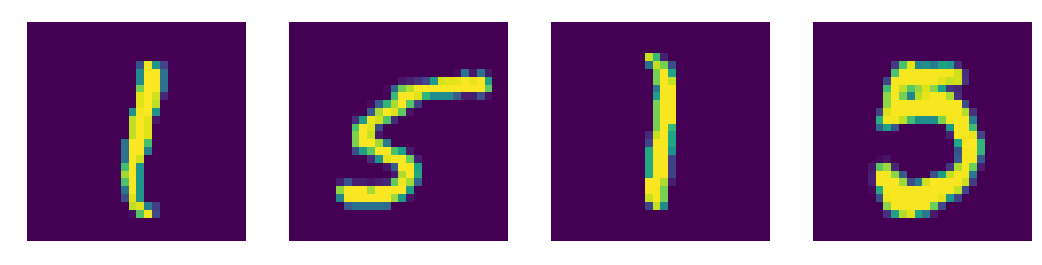

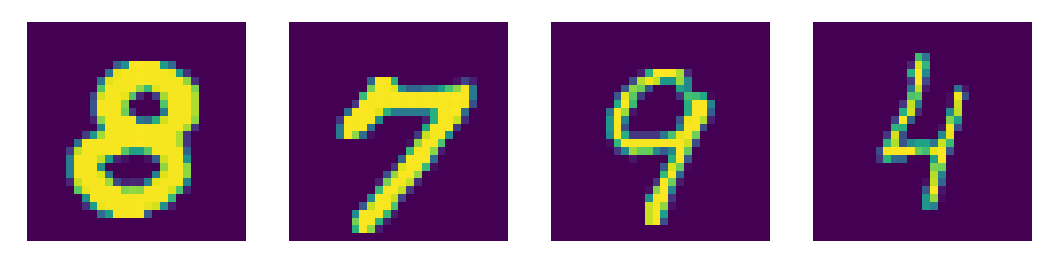

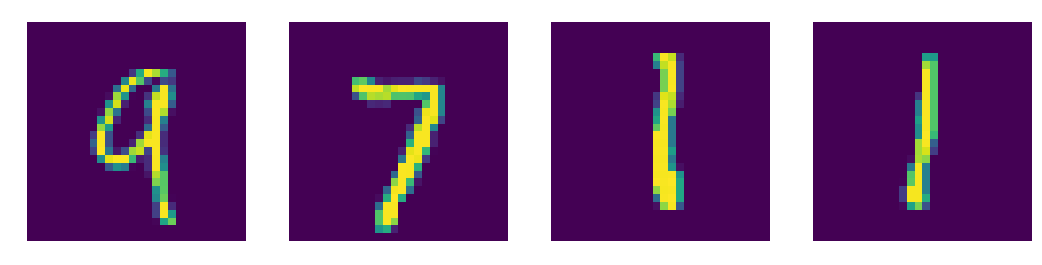

In [13]:
# Display last test batch

display_images(None, x, 4, count=True)

In [18]:
z_loc[B].data.shape

torch.Size([50])

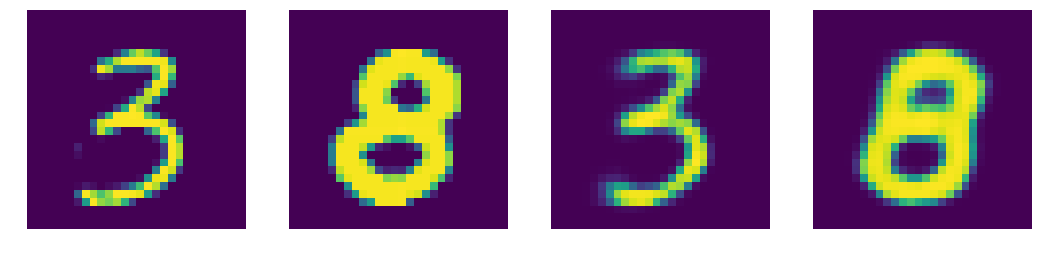

In [20]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 8
sample = vae.decoder(torch.stack((z_loc[A].data, z_loc[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

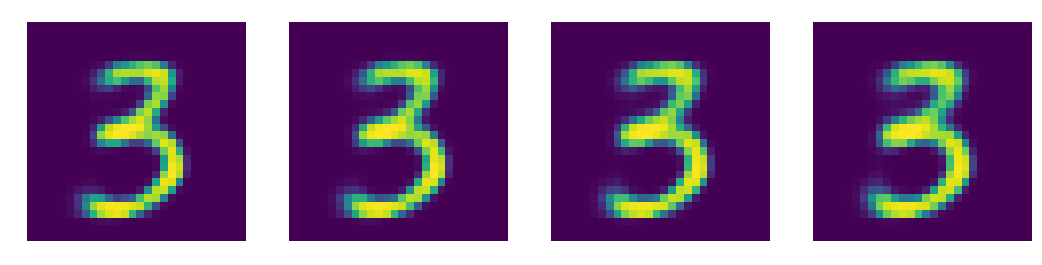

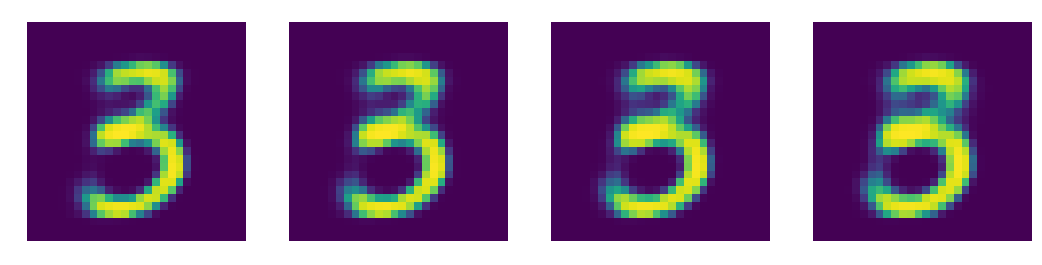

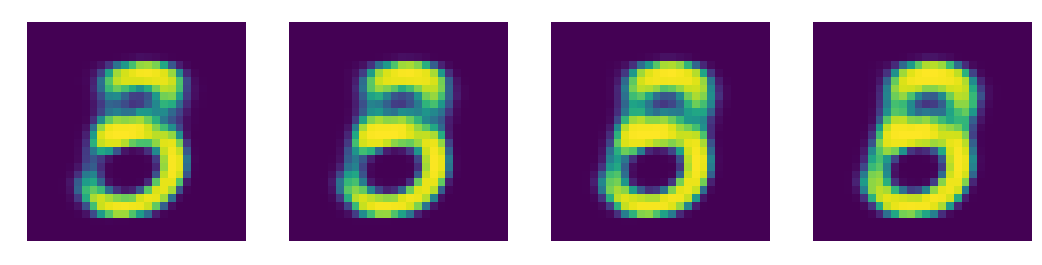

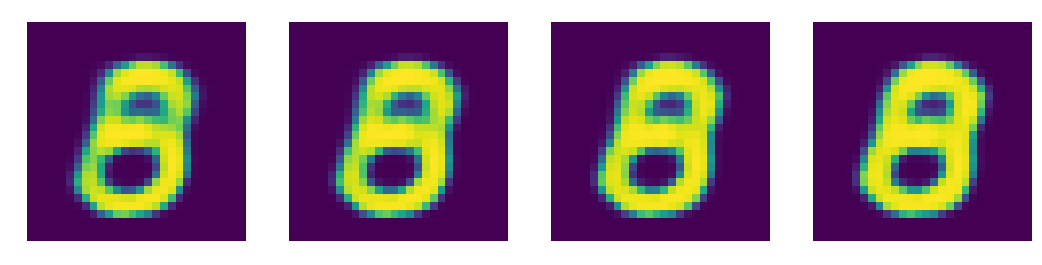

In [22]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 50).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * z_loc[B].data + (1 - i / (N - 1) ) * z_loc[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = vae.decoder(code)
display_images(None, sample, N // 4, count=True)